# Nigeria States Housing Price Prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

### Load Dataset

In [2]:
df = pd.read_csv('nigeria_houses_data.csv')
df.sort_values(by='price').head(10)

,bedrooms,bathrooms,toilets,parking_space,title,town,state,price
2693,2,3,3,4,Terraced Duplexes,Ibeju Lekki,Lagos,90000
20146,2,2,3,4,Detached Bungalow,Mowe Town,Ogun,100000
2385,5,7,7,4,Semi Detached Duplex,Maitama District,Abuja,110000
17645,7,7,8,6,Detached Duplex,Isheri North,Lagos,350000
2810,7,5,5,4,Detached Duplex,Isheri North,Lagos,350000
17940,7,5,5,4,Detached Duplex,Isheri North,Lagos,350000
7083,5,5,6,4,Detached Duplex,Lekki,Lagos,400000
2449,2,2,2,1,Detached Duplex,Asokoro District,Abuja,462837
4176,2,7,8,7,Detached Duplex,Jos South,Plateau,500000
14555,4,4,5,4,Semi Detached Duplex,Ikoyi,Lagos,660000


In [3]:
df.sort_values(by='price').tail(10)

,bedrooms,bathrooms,toilets,parking_space,title,town,state,price
20602,4,5,5,4,Block of Flats,Ikoyi,Lagos,15000000000
13490,3,3,3,4,Semi Detached Duplex,Ajah,Lagos,42000000000
17383,4,4,5,3,Detached Duplex,Ajah,Lagos,50000000000
15806,5,5,5,1,Detached Duplex,Ifako-Ijaiye,Lagos,55000000000
15836,5,6,7,4,Terraced Duplexes,Guzape District,Abuja,85000000000
7098,5,5,6,4,Semi Detached Duplex,Lekki,Lagos,125000000000
4327,5,5,6,4,Detached Duplex,Lekki,Lagos,160000000000
15962,9,9,1,4,Detached Duplex,Lekki,Lagos,350000000000
6632,4,4,5,4,Semi Detached Duplex,Ikoyi,Lagos,450000000000
4096,7,7,8,8,Detached Duplex,Ikoyi,Lagos,1800000000000


### Data Overview

In [4]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24326 entries, 0 to 24325
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   bedrooms       24326 non-null  int64 
 1   bathrooms      24326 non-null  int64 
 2   toilets        24326 non-null  int64 
 3   parking_space  24326 non-null  int64 
 4   title          24326 non-null  object
 5   town           24326 non-null  object
 6   state          24326 non-null  object
 7   price          24326 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 1.5+ MB


,bedrooms,bathrooms,toilets,parking_space,price
count,24326.000000,24326.000000,24326.000000,24326.000000,2.432600e+04
mean,4.338814,4.600798,5.176355,4.041725,3.013802e+08
std,1.138497,1.163161,1.226253,1.399936,1.220403e+10
min,1.000000,1.000000,1.000000,1.000000,9.000000e+04
25%,4.000000,4.000000,5.000000,4.000000,5.200000e+07
50%,4.000000,5.000000,5.000000,4.000000,8.500000e+07
75%,5.000000,5.000000,6.000000,4.000000,1.600000e+08
max,9.000000,9.000000,9.000000,9.000000,1.800000e+12


### Data Cleaning

In [5]:
df.duplicated().sum()

10438

In [6]:
# Remove duplicates
df = df.drop_duplicates(keep=False)
df.count()

bedrooms         11607
bathrooms        11607
toilets          11607
parking_space    11607
title            11607
town             11607
state            11607
price            11607
dtype: int64

**Check missing values**

In [7]:
# Check missing values
df.isnull().sum()

bedrooms         0
bathrooms        0
toilets          0
parking_space    0
title            0
town             0
state            0
price            0
dtype: int64

**Rename column**

In [8]:
df.rename(columns={"title": "property_type"}, inplace=True)

In [9]:
print('Shape:', df.shape)
df.head(3)

Shape: (11607, 8)


,bedrooms,bathrooms,toilets,parking_space,property_type,town,state,price
0,6,5,5,4,Detached Duplex,Mabushi,Abuja,450000000
1,4,5,5,4,Terraced Duplexes,Katampe,Abuja,800000000
3,4,4,5,6,Detached Duplex,Ajah,Lagos,40000000


## Exploratory Data Analysis
**Numbers of Unique states and towns.**

In [10]:
# Get unique values of state and town columns
unique_states = df['state'].nunique()
unique_towns = df['town'].nunique()

# Print results
print(f"There are {unique_states} unique states in the dataset")
print(f"There are {unique_towns} unique towns in the dataset")

There are 23 unique states in the dataset
There are 185 unique towns in the dataset


### Average Town House Price.

In [11]:
# Average price by town
town_mean_price = df.groupby('town')['price'].mean().sort_values(ascending=False)
town_mean_price

town
Ikoyi                4.056802e+09
Ifako-Ijaiye         8.199587e+08
Maitama District     7.191834e+08
Guzape District      6.709764e+08
Asokoro District     6.047135e+08
                         ...     
Jikwoyi              3.500000e+06
Egbeda               3.000000e+06
Yewa South           1.500000e+06
Eko Atlantic City    7.550000e+05
Jos South            5.000000e+05
Name: price, Length: 185, dtype: float64

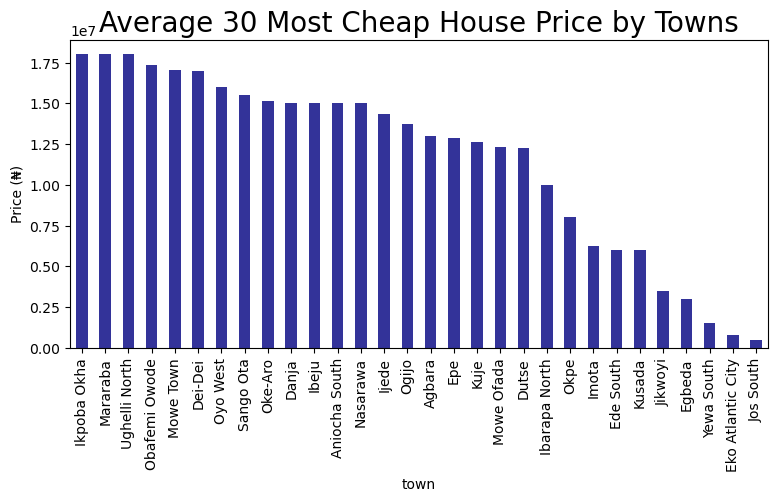

In [12]:
town_mean_price.sort_values(ascending=False)[-30:].plot(kind='bar', figsize=(9,4), cmap='terrain')
plt.title('Average 30 Most Cheap House Price by Towns', fontsize=20)
plt.ylabel("Price (₦)");

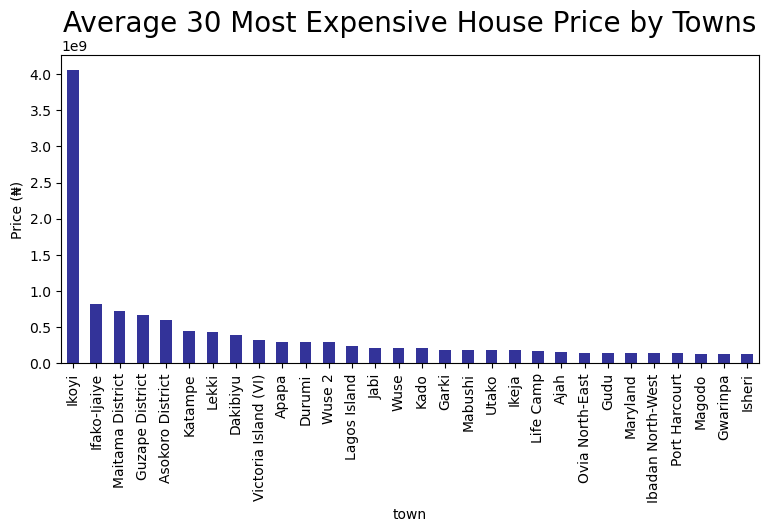

In [13]:
town_mean_price.sort_values(ascending=False)[:30].plot(kind='bar', figsize=(9,4), cmap='terrain')
plt.title('Average 30 Most Expensive House Price by Towns', fontsize=20)
plt.ylabel("Price (₦)");

### Average State House Price.

In [14]:
# Average price by state
state_mean_price = df.groupby('state')['price'].mean().sort_values(ascending=False)

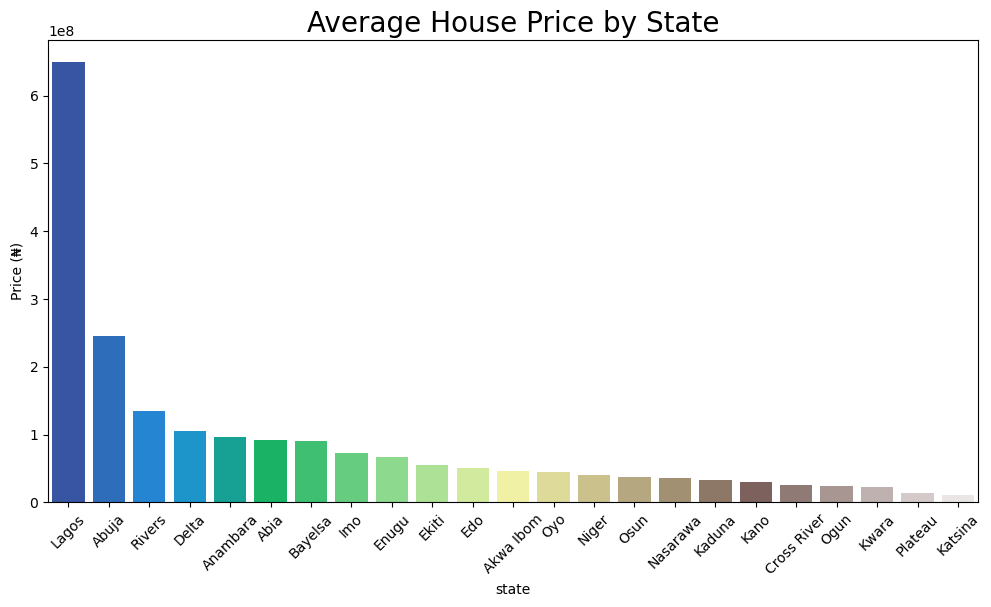

In [15]:
# Visualization
plt.figure(figsize=(12,6))
sns.barplot(x=state_mean_price.index, y=state_mean_price.values, palette="terrain")
plt.title("Average House Price by State", fontsize=20)
plt.ylabel("Price (₦)")
plt.xticks(rotation=45)
plt.show()

In [16]:
# Average price by property type
property_mean_price = df.groupby('property_type')['price'].mean().sort_values().reset_index()
property_mean_price

,property_type,price
0,Semi Detached Bungalow,3.831916e+07
1,Terraced Bungalow,4.504891e+07
2,Detached Bungalow,4.572213e+07
3,Terraced Duplexes,1.609671e+08
4,Block of Flats,1.697728e+08
5,Semi Detached Duplex,6.759094e+08
6,Detached Duplex,7.410002e+08


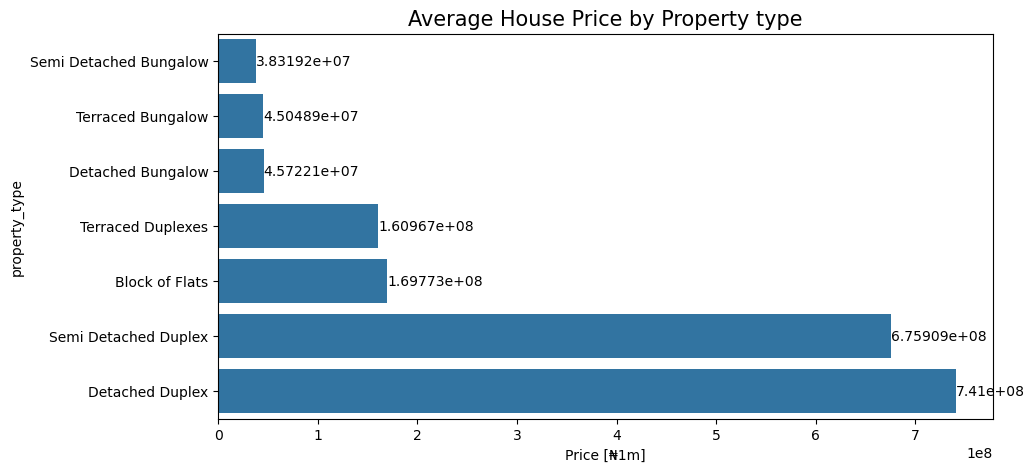

In [17]:
plt.figure(figsize=(10,5))
ax = sns.barplot(y='property_type', x='price',data=property_mean_price)
for container in ax.containers:
    ax.bar_label(container)
plt.title('Average House Price by Property type', fontsize=15)
plt.xlabel('Price [₦1m]');

### Create new column called Total rooms

In [18]:
df['total_rooms'] = (
    df['bedrooms'] + df['bathrooms']+ df['toilets'] + df['parking_space'])
df.tail()

,bedrooms,bathrooms,toilets,parking_space,property_type,town,state,price,total_rooms
24319,8,8,9,4,Detached Duplex,Guzape District,Abuja,1000000000,29
24320,3,4,4,5,Detached Duplex,Lekki,Lagos,80000000,16
24321,2,2,2,4,Block of Flats,Kabusa,Abuja,15000000,10
24322,4,5,5,4,Block of Flats,Ado-Odo/Ota,Ogun,25000000,18
24324,3,4,4,3,Block of Flats,Victoria Island (VI),Lagos,78000000,14


**Swap the positions of price column.**

In [19]:
# Swap the positions of the price and total_rooms columns
cols = list(df.columns)
cols[-1], cols[-2] = cols[-2], cols[-1]

df = df[cols]
df.head()

,bedrooms,bathrooms,toilets,parking_space,property_type,town,state,total_rooms,price
0,6,5,5,4,Detached Duplex,Mabushi,Abuja,20,450000000
1,4,5,5,4,Terraced Duplexes,Katampe,Abuja,18,800000000
3,4,4,5,6,Detached Duplex,Ajah,Lagos,19,40000000
7,2,2,3,6,Detached Bungalow,Epe,Lagos,13,12000000
8,1,1,1,1,Detached Duplex,Lekki,Lagos,4,200000000


### Correlation Map

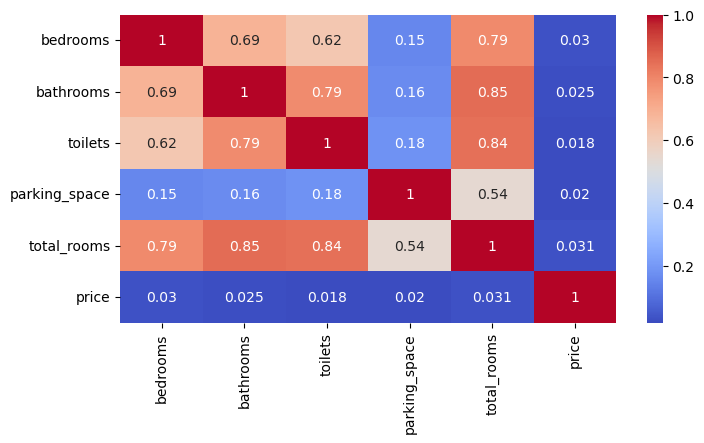

In [20]:
plt.figure(figsize=(8,4))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm');

### Correlation Heatmap (With Target)

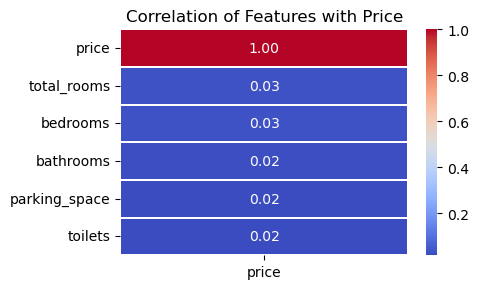

In [21]:
# Compute correlation matrix
corr_matrix = df.corr(numeric_only=True)

# Heatmap of correlations with target
plt.figure(figsize=(5, 3))
sns.heatmap(corr_matrix[['price']].sort_values(by='price', ascending=False),
            annot=True, cmap='coolwarm', fmt=".2f", linewidth=0.2)
plt.title('Correlation of Features with Price')
plt.tight_layout()

## Handle Outliers (IQR Method)

In [22]:
Q1 = df['price'].quantile(0.15)
Q3 = df['price'].quantile(0.85)
IQR = Q3 - Q1

df = df[(df['price'] >= Q1 - 1.5 * IQR) & (df['price'] <= Q3 + 1.5 * IQR)]

df.shape

(10890, 9)

### Saving a Clean Dataset

In [35]:
# Save clean dataset to new file
df.to_csv("nigeria_houses_data_clean.csv", index=False)

# Feature Selection
* **Split your data into Feature (x) and Target (y) Variables.**

In [23]:
X = df.drop('price', axis=1)        # Feature
y = df['price']                     # Target

* **Categorical and Numerical Columns.**

In [24]:
# Identify categorical and numerical columns
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(exclude=['object']).columns.tolist()

print("Categorical Columns:", cat_cols)
print("Numerical Columns:", num_cols)

Categorical Columns: ['property_type', 'town', 'state']
Numerical Columns: ['bedrooms', 'bathrooms', 'toilets', 'parking_space', 'total_rooms']


# Preprocessing Pipeline

In [25]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)

## Train-Test Split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Linear Regression Model

In [27]:
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

lr_pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Model Evaluation Function

In [28]:
def evaluate_model(model, X_test, y_test):
    preds = model.predict(X_test)

    print("MAE:", mean_absolute_error(y_test, preds))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, preds)))
    print("R2 Score:", r2_score(y_test, preds))

## Evaluate Linear Regression

In [29]:
evaluate_model(lr_pipeline, X_test, y_test)

MAE: 49807837.73551549
RMSE: 73518295.95888312
R2 Score: 0.4687679330350196


## Random Forest Model

In [30]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(
        n_estimators=100,
        random_state=42
    ))
])

rf_pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Evaluate Random Forest

In [31]:
evaluate_model(rf_pipeline, X_test, y_test)

MAE: 44352360.9694212
RMSE: 71531438.55145647
R2 Score: 0.4970933985667826


## Xgboost Regressor Model

In [32]:
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(random_state=42))
])

xgb_pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [33]:
evaluate_model(xgb_pipeline, X_test, y_test)

MAE: 42860428.0
RMSE: 68548889.91988873
R2 Score: 0.5381571054458618


## Save the best trained model.

In [34]:
import joblib

# Save the trained pipeline
joblib.dump(xgb_pipeline, "house_price_model.pkl")

['house_price_model.pkl']

# Great Job!!